In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v2'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0815_133911'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, _ = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='split', batch_size=2)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 49


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            vis_result = viz(batch,pred)
    # if i ==5:
    
            break   
model.metrics.update(pred,batch)


In [4]:
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)

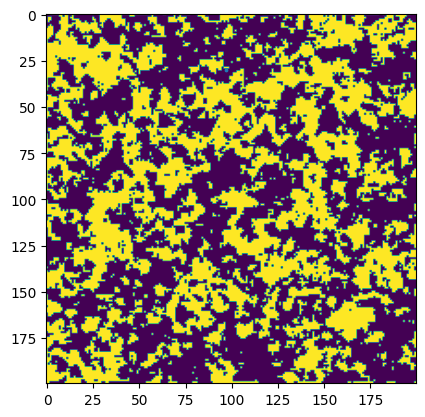

In [5]:
plt.imshow(((pred['VEHICLE'][0,0].sigmoid().detach().cpu())>0.5).numpy())
plt.scatter([97],[30], s=3)

In [6]:
for i,batch in enumerate(loader):
    break

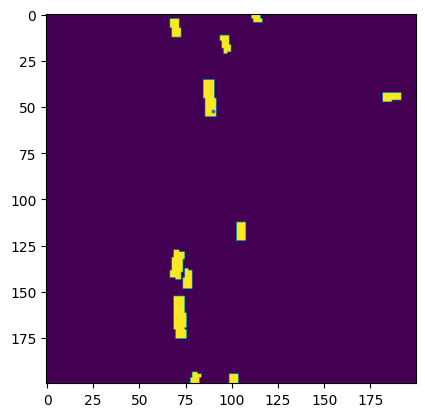

In [7]:
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
plt.imshow(vehicles[0,0].cpu().numpy())
plt.scatter([90],[52], s=3)

tensor([ 0.0389, -2.2416, -3.4587,  1.5993, -3.7210, -3.2054, -2.9130,  1.2077],
       device='cuda:0', grad_fn=<SelectBackward0>)


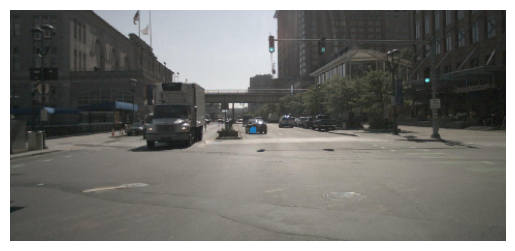

In [8]:
# mean height supervised
# x = [[[0.4953, 0.5759]],

#         [[0.5010, 0.4154]],

#         [[0.4945, 0.3754]],

#         [[0.4951, 0.5243]],

#         [[0.4952, 0.5507]],

#         [[0.4949, 0.4746]],

#         [[0.4952, 0.4506]],

#         [[0.4962, 0.6852]]]

x = [[[0.4908, 0.5212]],

        [[0.4854, 0.5210]],

        [[0.4854, 0.5121]],

        [[0.4901, 0.5130]],

        [[0.4909, 0.5076]],

        [[0.4883, 0.5195]],

        [[0.4854, 0.5158]],

        [[0.4871, 0.5088]]]
# [[[0.3613, 0.4691]],

#         [[0.3504, 0.4794]],

#         [[0.3512, 0.4666]],

#         [[0.3532, 0.4743]],

#         [[0.3519, 0.4691]],

#         [[0.3686, 0.4761]],

#         [[0.3512, 0.4649]],

#         [[0.3527, 0.5019]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224
print(pred['height'][0,:,52, 90])
# x = x[2:6]
plt.imshow(batch['image'][0,1].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1],s=2)
plt.axis('off')
plt.show()

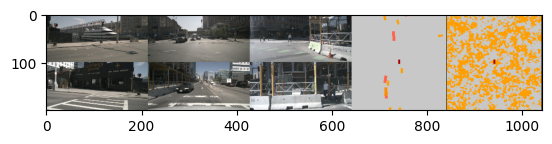

In [9]:
plt.imshow(vis_result[0])

In [10]:
visible = 0.006508241407573223
offset = 0.0038428744301199913
center = 0.002783437492325902
print(center/visible, offset/visible)

0.4276788948066669 0.5904627977764139


In [11]:
visible = 0.007961814291775227
offset = 0.004183642566204071
center = 0.0031685323920100927
print(center/visible, offset/visible)

0.3979661262990364 0.5254634701196044


(-0.5, 199.5, 199.5, -0.5)

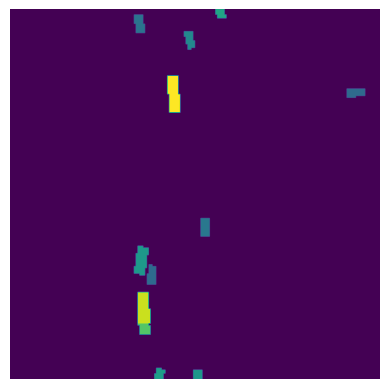

In [12]:
plt.imshow(batch['height'][0,0].cpu().numpy())
plt.axis('off')